# Project 2 - Sequential Models in NLP - Sarcasm Detection

## Import Libraries

In [113]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re,string
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [114]:
import os
os.chdir('/content/drive/MyDrive/NLP/')

## Read and explore the data

In [115]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [116]:
# Checking for NaN values
df.isna().sum() 

is_sarcastic    0
headline        0
article_link    0
dtype: int64

## Drop one column

In [117]:
# Deleting this column as it is of no use
del df['article_link'] 
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


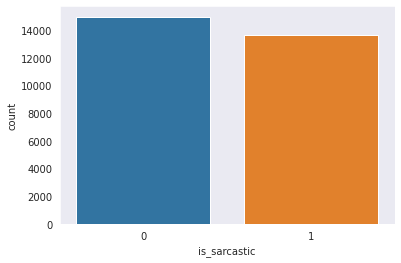

In [118]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

#### Conclusion : So, we can see that the dataset is balanced.

### Basic Data Cleaning

#### What are stopwords?

Stopwords are the English words which do not add much meaning to a sentence. They can be safely ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured in this nltk corpus.

In [119]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [120]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

## Get length of each sentence and vocab size

In [121]:
words = []
len_sentences = []
for i in df.headline.values:
    len_sentences.append(len(i))
    words.append(i.split())
print(len_sentences[:5])
print(len(words))

[58, 69, 44, 44, 58]
28619


## Create features and labels

In [122]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

## Define parameters

In [123]:
max_features = 35000
maxlen = 200
batch_size = 1024
epochs = 1
embed_size = 200

In [124]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [125]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

## Create a weight matrix using GloVe embeddings 

In [126]:
EMBEDDING_FILE = 'glove.twitter.27B.200d.txt'

In [127]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8"))

## Get indices for words

In [128]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

## Define and compile a Bidirectional LSTM model

In [129]:
#Defining Model
model = Sequential()
#Non-trainable embedding layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#Bidirectional LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [130]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          5165000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 5,502,153
Trainable params: 5,502,153
Non-trainable params: 0
_________________________________________________________________


## Fit the model and check the validation accuracy

In [134]:
try:
    model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)
except:
    pass   

12/20 [=================>............] - ETA: 2:24 - loss: 0.5678 - acc: 0.7054

In [135]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

269/269 [==============================] - 41s 154ms/step - loss: 0.5126 - acc: 0.7576
Accuracy of the model on Testing Data is -  75.76286792755127


In [137]:
pred = (model.predict(X_test) > 0.5).astype("int32")
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [138]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.73      0.87      0.79      4560
    Sarcastic       0.81      0.63      0.71      4026

     accuracy                           0.76      8586
    macro avg       0.77      0.75      0.75      8586
 weighted avg       0.77      0.76      0.75      8586



In [139]:
cm = confusion_matrix(y_test,pred)
cm

array([[3971,  589],
       [1492, 2534]])

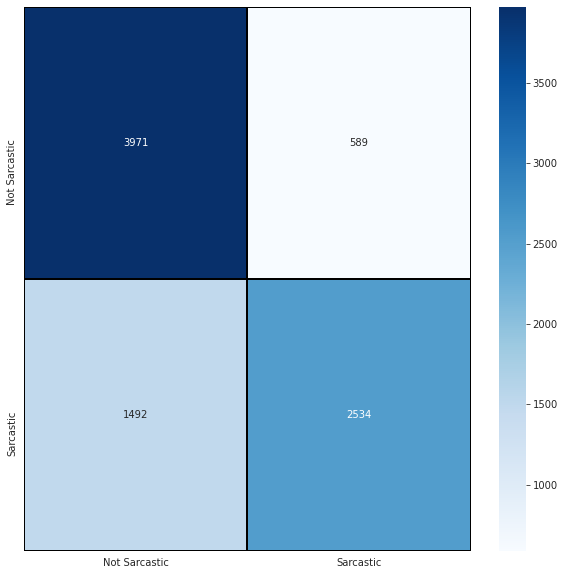

In [140]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])